# TP : Random Forest / Boosting appliquésau Titanic

## import des librairies

In [4]:
import pandas as pd
import numpy as np
import os

from IPython.display import Image

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

## 1. Lecture des fichiers de données
1.1 Lire le Dataframe train (avec le champs Survived). Afficher les 10 premières lignes.

In [5]:
train = pd.read_csv('Data/train_clean.csv', dtype={'PassengerId': np.int})
train.sample(10)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
9,10,1,2,0,0,2,1,0,3
125,126,1,3,1,0,1,1,0,4
480,481,0,3,1,0,3,0,0,4
436,437,0,3,0,1,3,0,0,2
284,285,0,1,1,2,2,0,1,1
712,713,1,1,1,2,3,0,0,1
583,584,0,1,1,2,3,1,1,1
840,841,0,3,1,1,1,0,1,1
573,574,1,3,0,1,0,2,1,2
577,578,1,1,0,2,3,0,0,3


1.2 Lire le Dataframe test (sans le champs Survived) dans les fichiers train_clean.csv. Afficher les 10 premières lignes.

In [6]:
test = pd.read_csv('Data/test_clean.csv', dtype={'PassengerId': np.int})
test.sample(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
19,911,3,0,2,0,1,1,3
211,1103,3,1,2,0,0,1,1
137,1029,2,1,1,1,0,1,1
319,1211,2,1,1,3,0,0,1
165,1057,3,0,1,2,0,0,3
374,1266,1,0,3,3,0,0,3
224,1116,1,0,3,2,1,1,3
388,1280,3,1,1,0,2,1,1
339,1231,3,1,2,0,1,1,4
155,1047,3,1,1,0,0,1,1


##  Préparation des données de Training

1.3 Charger les features d'apprentissage dans un array numpy X_alltrain. Afficher le type de X_alltrain les 10 premières lignes.

In [7]:
X_alltrain = train[train.columns[2:]].values
print(type(X_alltrain))
X_alltrain[0:10]

<class 'numpy.ndarray'>


array([[3, 1, 1, 0, 0, 0, 1],
       [1, 0, 2, 3, 1, 0, 3],
       [3, 0, 1, 1, 0, 1, 2],
       [1, 0, 2, 3, 0, 0, 3],
       [3, 1, 2, 1, 0, 1, 1],
       [3, 1, 1, 1, 2, 1, 1],
       [1, 1, 3, 3, 0, 1, 1],
       [3, 1, 0, 2, 0, 0, 4],
       [3, 0, 1, 1, 0, 0, 3],
       [2, 0, 0, 2, 1, 0, 3]])

1.4 Charger les labels dans un array numpy y_alltrain. Afficher les 10 premières lignes.

In [8]:
Y_alltrain = np.array(train.Survived.values)
print(type(Y_alltrain))
Y_alltrain[0:10]

<class 'numpy.ndarray'>


array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1])

1.5 Séparer les features et les labels en deux parties (train et dev). afficher les nombres de lignes et de colonnes pour les 4 arrays.

In [9]:
[x_train, x_dev, y_train, y_dev] = train_test_split(X_alltrain, Y_alltrain, random_state=42)
print('Size x_train {}'.format(x_train.shape))
print('Size x_dev {}'.format(x_dev.shape))
print('Size y_train {}'.format(y_train.shape))
print('Size y_dev {}'.format(y_dev.shape))

Size x_train (668, 7)
Size x_dev (223, 7)
Size y_train (668,)
Size y_dev (223,)


1.6 Afficher les noms des features.

In [10]:
train_feature_names = train.columns[2:].values

## Fonction Utilitaires (cadeau de la maison)

In [11]:
# Fonctions permettant de générer le fichier d'envoi à Kaggle
#parametres: Classifiers; Données à calculer ; index)

def generer_resultats(clf,df_test=test):
    """
    Fonctions permettant de générer le fichier d'envoi à Kaggle.
    On passe un classifier sur lequel on refait le training avec toutes les données de training
    
    Parameters
    ----------
    Classifiers : Classifier utilisé pour la prédiction
    data : Données à calculer. par défaut, les valeurs du dataset "test"
    idx : Index des passagers testés. Stockés dans finalfile_index lors de la lecture des données
    """    
    data = df_test.iloc[:,1:].values
    idx = df_test.PassengerId
    print(clf.get_params())
    clf.fit(X_alltrain, Y_alltrain)
    prediction=clf.predict(data)
    results=pd.DataFrame(prediction.astype(int), index = df_test.PassengerId, columns=['Survived'])
    results.to_csv('resultats%s.csv'%clf.__class__.__name__)
    
#Fonction pour l'affichage 2 D des résultats    

def plot_decision_boundary(clf,X,y, axes=[-0, 30, -5, 5], axis_name=['x1','x2'],alpha=0.5, contour=True):
    """
    Fonction pour l'affichage 2 D des résultats   
    
    Parameters
    ----------
    clf : Classifier à afficher
    X : features de Données a afficher
    y : labels de Données a afficher  
    axes : : Tailles des axes (valeur min/max)
    axis_name : Nom des axes sur le graphique
    alpha : Transparence des points
    contour : Afichage du contour
    """     
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bo",label="Disparu", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "ys", label="Rescapé",alpha=alpha)
    plt.axis(axes)
    plt.xlabel(axis_name[0], fontsize=18)
    plt.ylabel(axis_name[1]+ "  ",fontsize=18, rotation=0)    
    plt.legend(loc="lower right", fontsize=14)

## Exercice 2 : Arbre de Décision
2.1 En utilisant l'exemple 1, contruisez et entrainez un arbre de décision pour prévoir la survie. <br>

In [12]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_alltrain, Y_alltrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

2.2 Appliquer le modèle sur vos données de dev

In [13]:
x_pred = tree_clf.predict(x_dev)
accuracy_score(y_dev, x_pred)


0.7713004484304933

2.3 : Essayez plusieurs valeurs pour max_depth et garder le meilleur résultat

2.3 : Affichez l'arbre

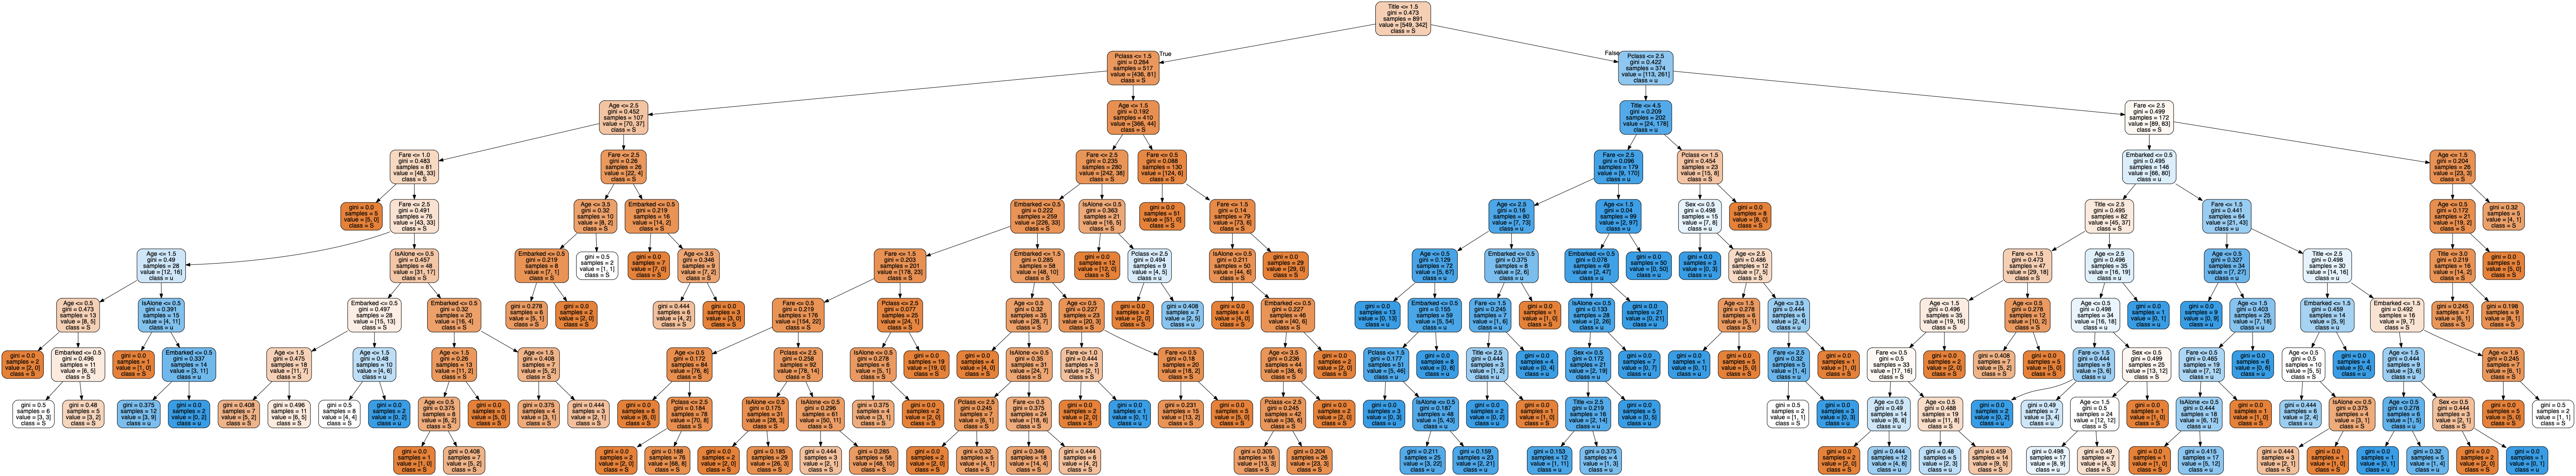

In [14]:
def fun_l(x):
    tree_clf.max_depth = x
    tree_clf.fit(X_alltrain, Y_alltrain)
    x_pred = tree_clf.predict(x_dev)
    return accuracy_score(y_dev, x_pred)
list(map(lambda x: fun_l(x), [9]))


export_graphviz(
        tree_clf,
        out_file="titanic_tree.dot",
        feature_names=train_feature_names,
        class_names='Survived',
        rounded=True,
        filled=True
    )

os.system("dot -Tpng titanic_tree.dot -o tree.png")
Image('tree.png')

2.4 Générez le fichier de résultats et envoyer une soumission sur Kaggle

In [15]:
generer_resultats(tree_clf)

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 42, 'splitter': 'best'}


2.5 Question : Quel est votre meilleur score et Classement ?

Classement: 3619

Score: 0.78947

## Exercice 3 : Random Forest
3.1 En utilisant l'exemple 5, Réalisez un algorithme de Random Forest sur les données Titanic. <br>

In [16]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(X_alltrain, Y_alltrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

3.2 Classez les features par ordre d'importance.

In [17]:
to_sort = []
for name, score in zip(train_feature_names, rnd_clf.feature_importances_):
   to_sort.append({'name': name, 'score': int(score*100)})
newlist = sorted(to_sort, key=lambda k: k['score'], reverse=True) 
newlist

[{'name': 'Title', 'score': 27},
 {'name': 'Sex', 'score': 21},
 {'name': 'Pclass', 'score': 17},
 {'name': 'Age', 'score': 11},
 {'name': 'Fare', 'score': 11},
 {'name': 'Embarked', 'score': 6},
 {'name': 'IsAlone', 'score': 3}]

3.3 Tester dans une boucle différentes valeurs pour max_depth et max_features de l'arbre et pour le nombre d'estimateurs.

In [24]:
bestAccuracyScore, bestDepthCount, bestFeatureCount, bestEstimatorCount = 0,0,0,0
for estimatorCount in range(200, 600, 100):
  for depthCount in range(5, 15, 1):
    for featureCount in range(1, len(train.columns[2:]), 1):
      randomClassfier = RandomForestClassifier(n_estimators=estimatorCount, n_jobs=-1, random_state=42, max_depth=depthCount, max_features=featureCount)
      randomClassfier.fit(X_alltrain, Y_alltrain)
      tempAccuracyScore = accuracy_score(y_dev, randomClassfier.predict(x_dev))
      if tempAccuracyScore > bestAccuracyScore:
        bestRandomClassfier = randomClassfier
        bestAccuracyScore, bestDepthCount, bestFeatureCount, bestEstimatorCount = tempAccuracyScore,depthCount,featureCount,estimatorCount
print("Best accuracyScore : %f (depth=%i, feature=%i, estimator=%i)" % (bestAccuracyScore, bestDepthCount, bestFeatureCount, bestEstimatorCount))

Best accuracyScore : 0.874439 (depth=9, feature=6, estimator=200)


3.4 Générer un fichier et envoyer les résultats sur Kaggle. Ecrivez ici vos résultats.

In [26]:
generer_resultats(bestRandomClassfier)
print("Classement: 3638")
print("Score: 0.78947")

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 6, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## Exercice 3 : Affichage de résultats
3.1 En utilisant la fonction plot_decision_boundary, afficher les résultats pour de l'arbre seul et du modèle de forêt les variables Fare et Title

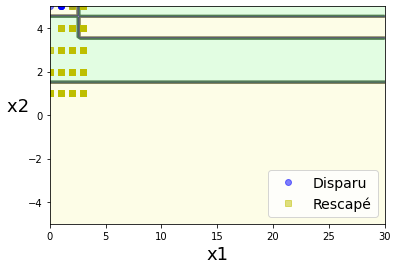

In [41]:
custom_x_alltrain = train[['Fare', 'Title']].values
another_rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, max_depth=6)
another_rnd_clf.fit(custom_x_alltrain, Y_alltrain)
plot_decision_boundary(another_rnd_clf, custom_x_alltrain, Y_alltrain)

## Exercice 4 : Boosting
4.1 En vous inspirant de l'exemple 6, Testez ici Adaboost et le gradient Boosting

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier


ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=100,
    algorithm="SAMME.R", learning_rate=0.3, random_state=42)
ada_clf.fit(X_alltrain, Y_alltrain)

gb = GradientBoostingClassifier(n_estimators=500,
                                random_state=0)
gb.fit(X_alltrain, Y_alltrain)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

4.2 Afficher les résultats. Essayer differents paramètres de Learning Rate, nombre d'estimateurs, taille des arbres ...

In [59]:
bestAdaAccuracyScore, bestAdaDepthCount, bestAdaLearningRate, bestAdaEstimatorCount = 0,0,0,0
bestGradiantAccuracyScore, bestGradiantDepthCount, bestGradiantLearningRate, bestGradiantEstimatorCount = 0,0,0,0
for estimatorCount in range(200, 600, 100):
  for depthCount in range(5, 15, 1):
    for learningRate in np.arange(0.3, 0.5, 0.1):
      
        ada_clf = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=depthCount), n_estimators=estimatorCount,
            algorithm="SAMME.R", learning_rate=learningRate, random_state=42)
        ada_clf.fit(X_alltrain, Y_alltrain)

        tempAdaAccuracyScore = accuracy_score(y_dev, ada_clf.predict(x_dev))
        if tempAdaAccuracyScore > bestAdaAccuracyScore:
            bestAdaClassfier = ada_clf
            bestAdaAccuracyScore, bestAdaDepthCount, bestAdaLearningRate, bestAdaEstimatorCount = tempAdaAccuracyScore,depthCount,learningRate,estimatorCount


        gb = GradientBoostingClassifier(n_estimators=estimatorCount,
                                        random_state=42)
        gb.fit(X_alltrain, Y_alltrain)

        tempGradiantAccuracyScore = accuracy_score(y_dev, gb.predict(x_dev))
        if tempGradiantAccuracyScore > bestGradiantAccuracyScore:
            bestGradiantClassfier = gb
            bestGradiantAccuracyScore, bestGradiantDepthCount, bestGradiantLearningRate, bestGradiantEstimatorCount = tempGradiantAccuracyScore,depthCount,learningRate,estimatorCount

print("Best Ada accuracyScore : %f (depth=%i, feature=%i, estimator=%i)" % (bestAdaAccuracyScore, bestAdaDepthCount, bestAdaLearningRate, bestAdaEstimatorCount))
print("Best Gradiant boosting accuracyScore : %f (depth=%i, feature=%i, estimator=%i)" % (bestGradiantAccuracyScore, bestGradiantDepthCount, bestGradiantLearningRate, bestGradiantEstimatorCount))

Best Ada accuracyScore : 0.869955 (depth=6, feature=0, estimator=200)
Best Gradiant boosting accuracyScore : 0.865471 (depth=5, feature=0, estimator=400)


4.3 Appliquez le "Early Stopping" sur le nombre d'estimateurs

In [61]:
gbes = GradientBoostingClassifier(n_estimators=500,
                                  n_iter_no_change=5, tol=0.0001,
                                  random_state=0)
gbes.fit(X_alltrain, Y_alltrain)
accuracy_score(y_dev, gbes.predict(x_dev))

0.8385650224215246

4.4 Générer un fichier et envoyer les résultats sur Kaggle. Ecrivez ici vos résultats.

In [64]:
generer_resultats(gbes)

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_iter_no_change': 5, 'presort': 'deprecated', 'random_state': 0, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [ ]:
print('Classement: 3644')
print('Score: 0.78947')